In [2]:
from glob import iglob
from functools import reduce, partial

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType, size, col, lit, explode
import matplotlib.pyplot as plt
from numpy import linspace, histogram, histogram2d, array
from numba import jit
from dask import compute
from dask.diagnostics import ProgressBar
import dask.array as da

from sp8tools import SpkHits

Connect to Spark master

In [2]:
builder = (SparkSession
           .builder
           .appName("PySpark Example")
           .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.15")
           .config("spark.cores.max", 4)
#            .config("spark.executor.cores", 4)
           .config("spark.executor.memory", "8g")
           )
spark = builder.getOrCreate()

Read root files

In [3]:
globbed = iglob("/helium/analysis/saito/SortEvent_aq002_t100_b.root")
roots = (spark.read.format("org.dianahep.sparkroot").load(fn) for fn in globbed)
df = reduce(DataFrame.unionAll, roots)
df.printSchema()

root
 |-- SortedEvent: struct (nullable = true)
 |    |-- fEventID: long (nullable = true)
 |    |-- fDetektors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- fDetektors_fHits: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- fPDNbr: integer (nullable = true)
 |    |    |    |    |    |-- fHitNbr: integer (nullable = true)
 |    |    |    |    |    |-- fU1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fU2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fMcpNbr: integer (nullable = true)
 |    |    |    |    |    |-- fX_mm: double (nullable = true)
 |    |    |    |    |    |-- fY_mm: double (

Restruct

In [4]:
@udf(SpkHits)
def combine_hits(xarr, yarr, tarr, flagarr):
    return [{'x': x,
             'y': y,
             't': t,
             'flag': f
            } for x, y, t, f in zip(xarr, yarr, tarr, flagarr)]


chits = col('SortedEvent.fDetektors')[0]['fDetektors_fHits']
restructed = (df
              .withColumn('hits', combine_hits(chits.getField('fX_mm'),
                                               chits.getField('fY_mm'),
                                               chits.getField('fTime'),
                                               chits.getField('fRekmeth')))
              .select(col('SortedEvent.fEventID').alias("tag"), 'hits'))
restructed.printSchema()

root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)
 |    |    |-- as: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)



# Covariance map

Load data to Memory

In [5]:
loaded = (restructed
          .filter(size('hits')!=0)
          .select('hits.t')
          .collect()
          )
spark.stop()

Estimate covariance

In [ ]:
%%time
bin_config = {'bins': 500, 'range': (2000, 4000)}

arrs = [da.from_array(array(arr), chunks=-1) for arr in loaded]
hists = [da.histogram(arr, **bin_config)[0] for arr in arrs]
stacked = da.stack(hists, axis=-1).rechunk((None, 10000))

with ProgressBar():
    cov2d = da.cov(stacked).compute()

Plot

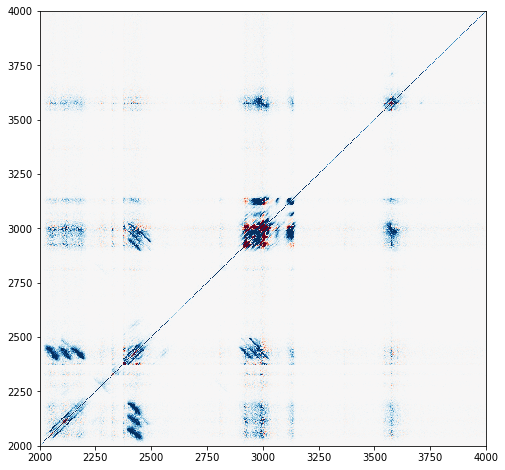

In [9]:
edges = linspace(*bin_config['range'], bin_config['bins']+1)

clim = 0.0002
plt.figure(figsize=(8, 8))
plt.pcolormesh(edges, edges, cov2d, cmap='RdBu')
plt.clim(-clim, clim)
# plt.colorbar()
plt.show()

# Covariance map 2

In [ ]:
%%time
bin_config = {'bins': 500, 'range': (2000, 4000)}

arrs = [da.from_array(array(arr), chunks=-1) for arr in loaded]
hists = [da.histogram(arr, **bin_config)[0] for arr in arrs]
stacked = da.stack(hists).rechunk((10000, None))
n, *_ = stacked.shape
summed1 = da.einsum('ij->j', stacked)
summed2 = da.einsum('ij,ik->jk', stacked, stacked)
diff2 = summed2/n - summed1[:, None]*summed1[None, :]/(n**2)

with ProgressBar():
    tof, pipico, cov2d = compute(summed1, summed2, diff2)

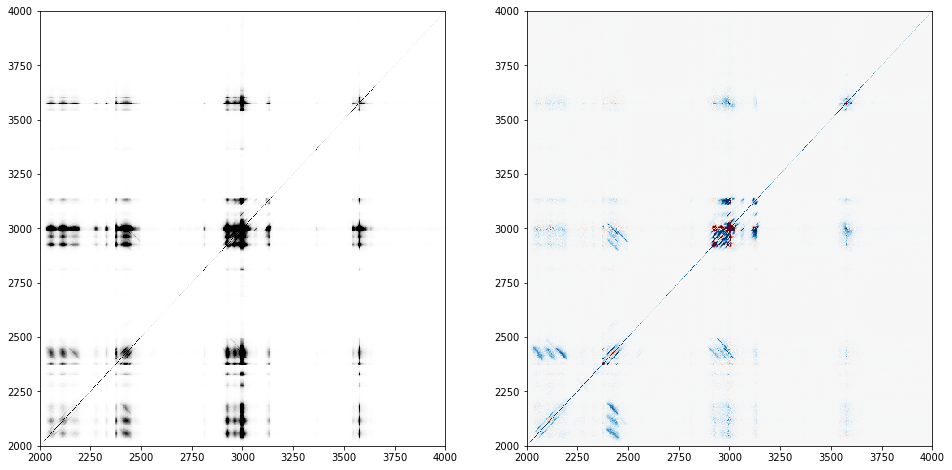

In [44]:
edges = linspace(*bin_config['range'], bin_config['bins']+1)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(edges, edges, pipico, cmap='Greys')
plt.clim(0, 500)
# plt.colorbar()

clim = 0.0005
plt.subplot(122)
plt.pcolormesh(edges, edges, cov, cmap='RdBu')
plt.clim(-clim, clim)
plt.tight_layout()
plt.show()

# 3D covariance map

In [ ]:
%%time
bin_config = {'bins': 200, 'range': (2000, 4000)}

arrs = [da.from_array(array(arr), chunks=-1) for arr in loaded]
hists = [da.histogram(arr, **bin_config)[0] for arr in arrs]
stacked = da.stack(hists).rechunk((1, None))
n, *_ = stacked.shape
summed1 = da.einsum('ij->j', stacked)
summed2 = da.einsum('ij,ik->jk', stacked, stacked)
summed3 = da.einsum('ij,ik,il->jkl', stacked, stacked, stacked)
diff2 = summed2/n - summed1[:, None]*summed1[None, :]/(n**2)
diff3 = (summed3/n
         - summed2[:, :, None]*summed1[None, None, :]/(n**2)
         - summed1[:, None, None]*diff2[None, :, :]/n
         - summed1[None, :, None]*diff2[:, None, :]/n)

with ProgressBar():
    tof, pipico, pipipico, cov2d, cov3d = compute(
        summed1, summed2, summed3,
        diff2, diff3,
    )

daehyun20180715_1715 = {
    'tof': tof,
    'pipico': pipico,
    'pipipico': pipipico,
    'cov2d': cov2d,
    'cov3d', cov3d,
}
%store daehyun20180715_1715

In [1]:
if 'daehyun20180715_1715' not in locals():
    %store -r daehyun20180715_1715
    tof = daehyun20180715_1715['tof']
    pipico = daehyun20180715_1715['pipico']
    pipipico = daehyun20180715_1715['pipipico']
    cov2d = daehyun20180715_1715['cov2d']
    cov3d = daehyun20180715_1715['cov3d']

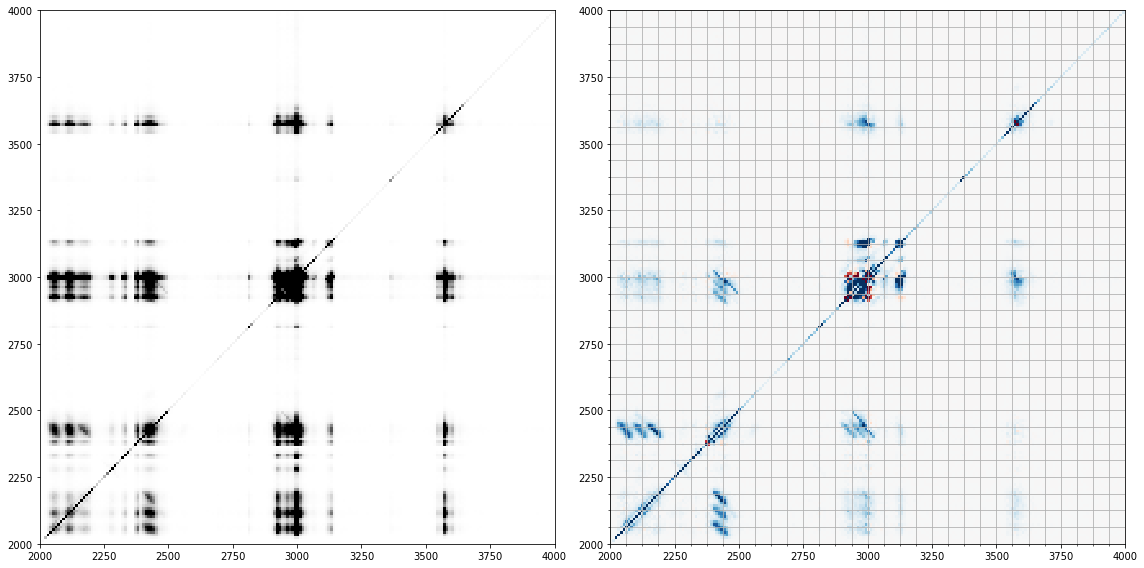

In [4]:
bin_config = {'bins': 200, 'range': (2000, 4000)}
edges = linspace(*bin_config['range'], bin_config['bins']+1)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(edges, edges, pipico, cmap='Greys')
plt.clim(0, 2000)
# plt.colorbar()

clim = 0.002
plt.subplot(122)
plt.pcolormesh(edges, edges, cov2d, cmap='RdBu')
plt.minorticks_on()
plt.grid(which='both')
plt.clim(-clim, clim)

plt.tight_layout()
plt.show()

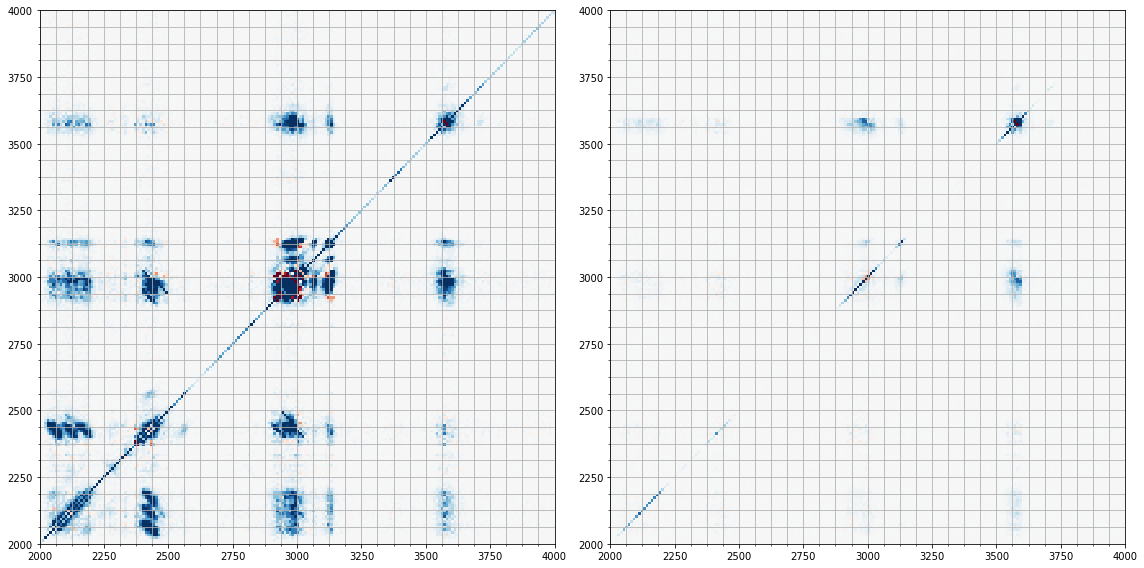

In [8]:
centers = (edges[1:] + edges[:-1]) / 2
# img = cov3d[(2400<centers) & (centers<2500), :, :].sum(0)
# img = cov3d[(2850<centers) & (centers<3050), :, :].sum(0)
img = cov3d[(2850<centers) & (centers<3050), :, :].sum(0)
# img = cov3d[(3500<centers) & (centers<3600), :, :].sum(0)

clim = 0.002
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(edges, edges, cov3d.sum(0), cmap='RdBu')
plt.minorticks_on()
plt.grid(which='both')
plt.clim(-clim, clim)

plt.subplot(122)
plt.pcolormesh(edges, edges, img, cmap='RdBu')
plt.minorticks_on()
plt.grid(which='both')
plt.clim(-clim, clim)

plt.tight_layout()
plt.show()